<a href="https://colab.research.google.com/github/paulantoine/covid_dept/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib as mpl
import matplotlib.ticker as mticker
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from google.colab import drive

mpl.rcParams['figure.figsize'] = [20.0, 8.0]
#plt.style.use('fivethirtyeight') #'seaborn-notebook'
#plt.rcParams.update({'font.size': 14})il
print("pandas version:", pd.__version__)

pandas version: 1.1.5


In [ ]:
ROOT = "/content/drive" 
drive.mount(ROOT)

MY_GOOGLE_DRIVE_PATH = 'My Drive/python/' 
GIT_USERNAME = "paulantoine" 
GIT_TOKEN = "xxx"  
GIT_REPOSITORY = "covid_lib" 
PROJECT_PATH = os.path.join(ROOT, MY_GOOGLE_DRIVE_PATH)
GIT_PATH = "https://" + GIT_TOKEN + "@github.com/" + GIT_USERNAME + "/" + GIT_REPOSITORY + ".git"

# Init
# !mkdir "{PROJECT_PATH}"    
# %cd "{PROJECT_PATH}"    # Change directory to the location defined in project_path
# !git clone "{GIT_PATH}" # clone the github repository

PROJECT_PATH = os.path.join(ROOT, MY_GOOGLE_DRIVE_PATH, GIT_REPOSITORY)
%cd "{PROJECT_PATH}"
!git pull
import covid_lib as cl

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/python/covid_lib
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/paulantoine/covid_lib
   9f726d0..69d3f2a  main       -> origin/main
Updating 9f726d0..69d3f2a
Fast-forward
 covid_lib.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)
reading données INSEE...
lecture des données INSEE sur la population française ok


In [ ]:
#title lecture des données

dept_data = cl.dept_data

hospi_dept = cl.read_hospi_dept()

hospi_age = cl.read_hospi_age()

cumul = cl.read_cumul()

test_age = cl.read_test_age()

sos_urgences = cl.read_sos_urgences()

test_dept = cl.read_test_dept()

dernier jour hospitalisations par département : 2021-04-02
dernier jour hospitalisations par age : 2021-04-02
dernier jour cumul : 2021-04-02
dernier jour tests par age : 2021-03-30
dernier jour sos médecins / urgences: 2021-04-01
dernier jour test dept : 2021-03-30


In [ ]:
# fonctions génériques

def display_df(df, legend=None, title="", logscale=False, zero=False):
  if not legend:
    legend=df.columns
  fig = plt.figure(figsize=(20,8))
  ax = plt.axes()
  if logscale:
      plt.yscale('log')
  ax.plot(df, marker="o")
  plt.xticks(rotation=75)
  plt.title(title, fontsize=22)
  plt.legend(legend, loc=2, fontsize=14)
  plt.grid()
  if zero:
    plt.axhline(0, color="r")
  tick_freq = df.shape[0] // 60
  myLocator = mticker.MultipleLocator(tick_freq)
  ax.xaxis.set_major_locator(myLocator)
  plt.show()

def window(df, min_date="2020-01-01", max_date="2022-01-01"):
  if "jour" in df.columns:
    return df[(df.jour >= min_date) & (df.jour <= max_date)]
  return df[(df.index>= min_date) & (df.index <= max_date)]

def dept_name(dept=None):
  if dept:
    return dept_data.loc[dept,"nom"]
  else:
    return "France"

In [ ]:

def prepare_hospi_dept(dept=None):
  if dept:
    daily = hospi_dept[hospi_dept.dep == dept].set_index("jour")[["incid_hosp", "incid_rea"]]
  else:
    daily = hospi_dept.groupby(["jour"])[["incid_hosp", "incid_rea"]].sum()

  lissage_hebdo = daily.rolling(7, center=True).mean()
  lissage_hebdo.columns = ["hosp_lisse", "rea_lisse"]

  return pd.concat([daily, lissage_hebdo], axis=1)

def variation_hospi_dept(dept=None):
  df = prepare_hospi_dept(dept)
  return df[["hosp_lisse", "rea_lisse"]].pct_change().rolling(5, center=True).mean()

def prepare_hospi_age(ages=None, normalize=False):
  """ages = liste des classes d'âges à afficher"""
  target = "hosp_norm" if normalize else "hosp"

  if ages:
    df = hospi_age[hospi_age.cl_age90.isin(ages)]
  else:
    df = hospi_age[hospi_age.cl_age90 > 0]
  return df.pivot_table(index="jour", columns="cl_age90", values=target, aggfunc=sum)

def prepare_rea_age(ages=None, normalize=False):
  target = "rea_norm" if normalize else "rea"
  if ages:
    df = hospi_age[hospi_age.cl_age90.isin(ages)]
  else:
    df = hospi_age[hospi_age.cl_age90 > 0]
  return df.pivot_table(index="jour", columns="cl_age90", values=target, aggfunc=sum)

def variation_hospi_age(ages=None):
  df = prepare_hospi_age(ages)
  return df.rolling(7, center=True).mean().pct_change().rolling(5, center=True).mean()

def prepare_test():
  return test_age[test_age.cl_age90 == 0].set_index("jour").rolling(7, center=True).mean()

def variation_test(lissage=5):
  return prepare_test().pct_change().rolling(lissage, center=True).mean()

def display_hospi_dept(dept=None, min_date="2020-01-01", max_date="2022-01-01"):
  display_df(
    window(prepare_hospi_dept(dept), min_date, max_date),
    legend=["hospitalisations", "réanimation", "hospitalisation 7j", "réanimation 7j"],
    title=dept_name(dept)
  )
  print_latest_hospi(dept)

def display_rea_dept(dept=None, min_date="2020-01-01", max_date="2022-01-01", logscale=False):
  title = "réa " + dept_name(dept) + (" (logscale)" if logscale else "")
  display_df(
    window(prepare_hospi_dept(dept)[["incid_rea","rea_lisse"]], min_date, max_date),
    legend=["réanimation", "réanimation 7j"],
    title=title,
    logscale=logscale
  )
  print_latest_hospi(dept)

def display_variation_hospi_dept(dept=None, min_date="2020-01-01", max_date="2022-01-01"):
  display_df(
      window(variation_hospi_dept(dept), min_date, max_date),
      legend=["hospitalisations", "réanimations"],
      title=dept_name(dept),
      zero=True
  ) 

def print_latest_hospi(dept=None):
  if dept:
    population = dept_data.loc[dept,"population"]
  else:
    population = dept_data.loc[:, "population"].sum()
  df = prepare_hospi_dept(dept)
  hospi_lisse = df["hosp_lisse"].dropna()[-10:]
  rea_lisse = df["rea_lisse"].dropna()[-10:]
  disp = ["incid_hosp", "incid_rea", "hosp_lisse", "rea_lisse"]
  print("\ndernières données :")
  print(df[disp].apply(np.rint).tail(4).head(1))
  print()
  print(f"hospitalisations pour 100k habitants {max(hospi_lisse)/ population * 100000:.2f}")
  print(f"réanimations pour 100k habitants     {max(rea_lisse)/ population * 100000:.2f}")



In [ ]:
df_test_dept = test_dept[(test_dept.dep == 75) & (test_dept.jour >= "2021")].set_index("jour")[["P"]]
df_test_dept["lisse"] = df_test_dept["P"].rolling(7, center=True).mean()
display_df(df_test_dept)

# Entrée en hospitalisation


## France

In [ ]:
#hospi_dept = hospi_dept[hospi_dept.jour <= "2020-07-01"]

In [ ]:
display_hospi_dept(min_date="2020-03-01")
#sns.lineplot(data=prepare_hospi_age())
mpl.rcParams['figure.figsize'] = [20.0, 8.0]

## par département

In [ ]:
display_hospi_dept("75", min_date="2020-09-01")

In [ ]:
display_hospi_dept("05", min_date="2020-09-01")

In [ ]:
display_hospi_dept("59", min_date="2020-09-01")

In [ ]:
dept = "93"
display_hospi_dept(dept, min_date="2020-10-01")

## par âge

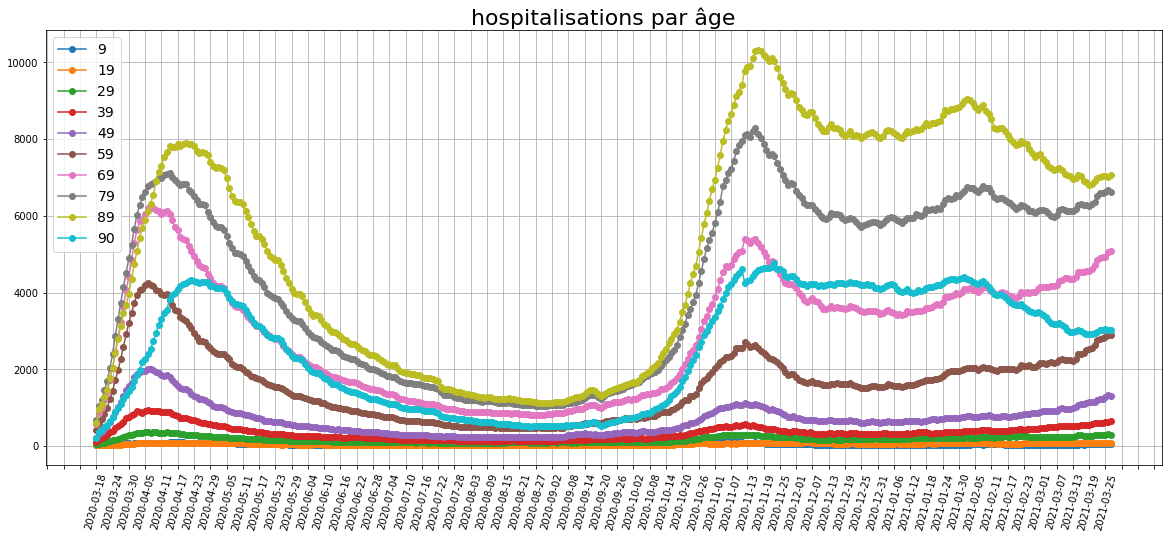

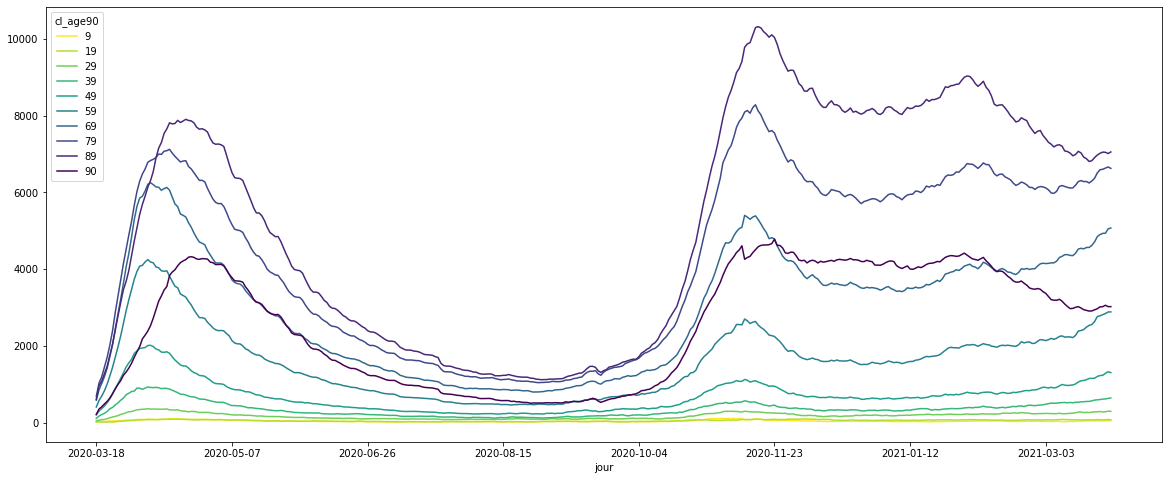

In [ ]:
# hospi par âge
display_df(window(prepare_hospi_age(), min_date="2020-03-01"), title="hospitalisations par âge")
df = window(prepare_hospi_age(), min_date="2020-03-01")
colors = pl.cm.viridis(np.linspace(0,1,df.shape[1]))[::-1]
df.plot(color=colors)

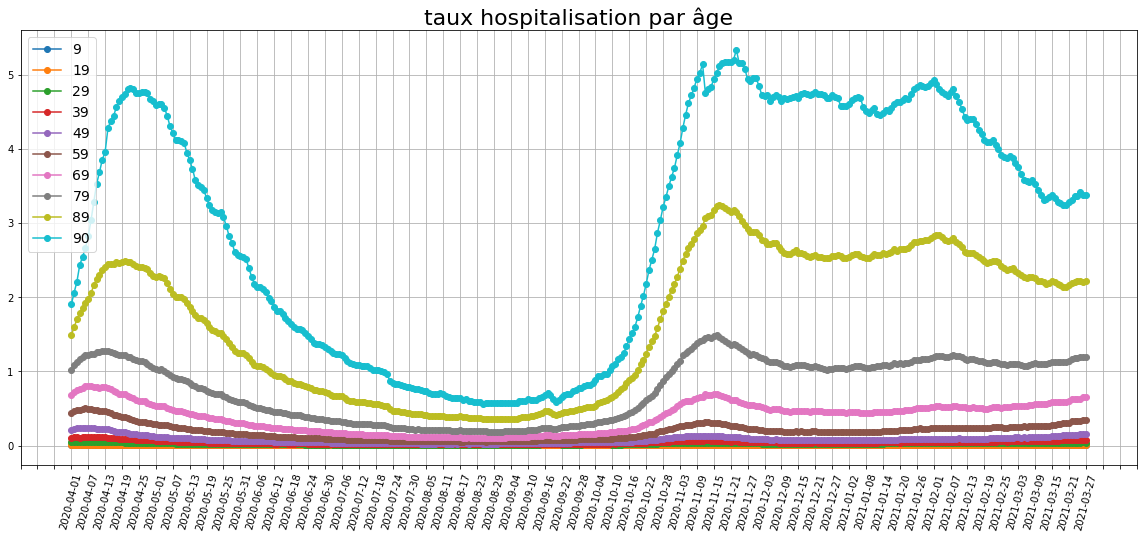

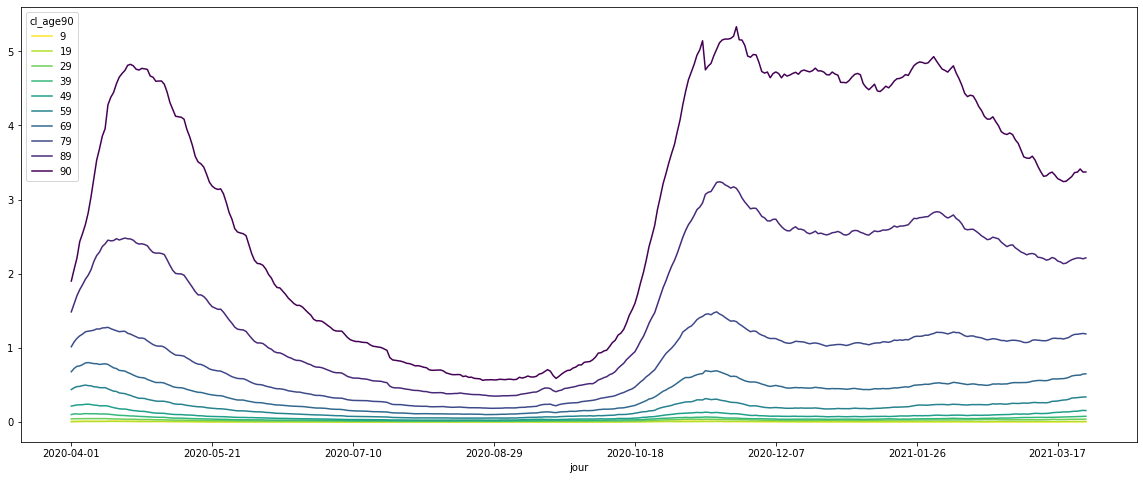

In [ ]:
display_df(window(prepare_hospi_age(normalize=True), min_date="2020-04-01"), title="taux hospitalisation par âge")

# color maps perceptually uniform: viridis, plasma
# color maps diverging : PiYG, seismic
df = window(prepare_hospi_age(normalize=True), min_date="2020-04-01")
colors = pl.cm.viridis(np.linspace(0,1,df.shape[1]))[::-1]
df.plot(color=colors)

In [ ]:
# taux hospitalisaiton par âge
df.head()
fig = go.Figure(data=go.Heatmap(
    z=df.T,
    x=df.index,
    y=np.arange(9,100,10), #df.columns,
    colorscale = 'Viridis',
    )
)
fig.show()

# tests PCR

## France

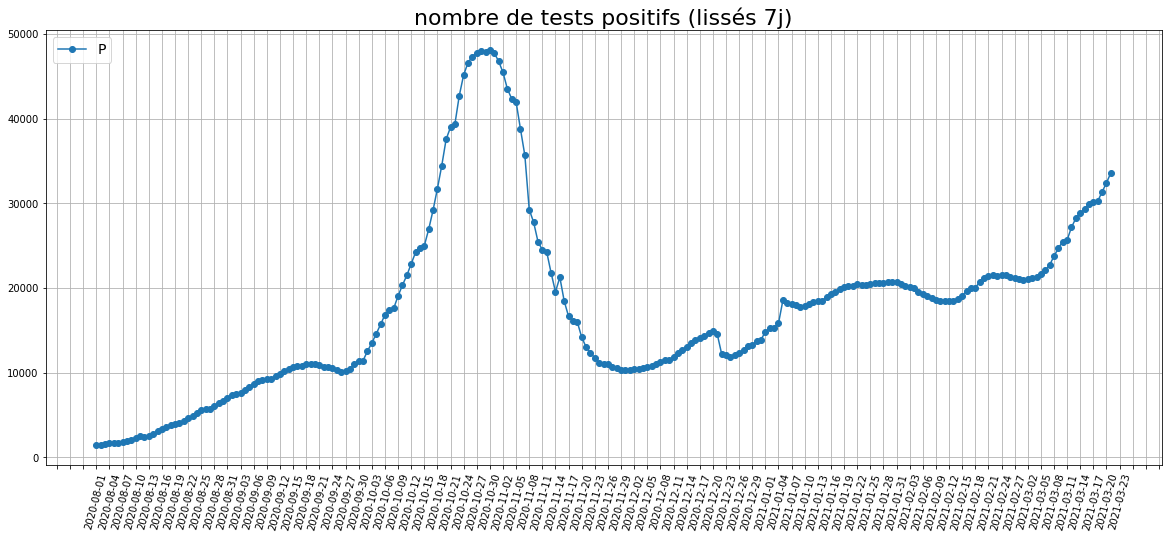

In [ ]:
display_df(window(prepare_test(), min_date="2020-08-01")[["P"]], title="nombre de tests positifs (lissés 7j)")

In [ ]:
#display_df(variation_test(lissage=3)[["P"]], title="variation du nombre de tests positifs", zero=True)

In [ ]:
#@markdown version plotly
df = window(prepare_test(), min_date="2020-08-01")[["T", "P"]].reset_index()
df["R"] = df["P"] / df["T"]
#figure with multiple y axis

trace1 = go.Scatter(
    x=df['jour'],
    y=df['T'],
    name='tests',
    mode='lines+markers',
    yaxis='y1')
trace2 = go.Scatter(
    x=df['jour'],
    y=df['P'],
    name='positifs',
    mode='lines+markers',
    yaxis='y2')

trace3 = go.Scatter(
    x=df["jour"],
    y=df["R"],
    name="taux",
    mode="lines",
    yaxis='y3')


data = [trace1, trace2, trace3]
layout = go.Layout(
    title='tests, tests positifs, taux de positivité',
    xaxis=dict(domain=[0.08, 1]),
    yaxis=dict(title='tests', title_standoff = 0),
    yaxis2=dict(title='positifs', overlaying='y', side='left', position=0, anchor="free", title_standoff = 0),
    yaxis3=dict(title='taux', overlaying='y', side='right', title_standoff = 0)
)
fig = go.Figure(data=data, layout=layout)
fig.update_yaxes(rangemode="tozero")
fig.show()

## par âge

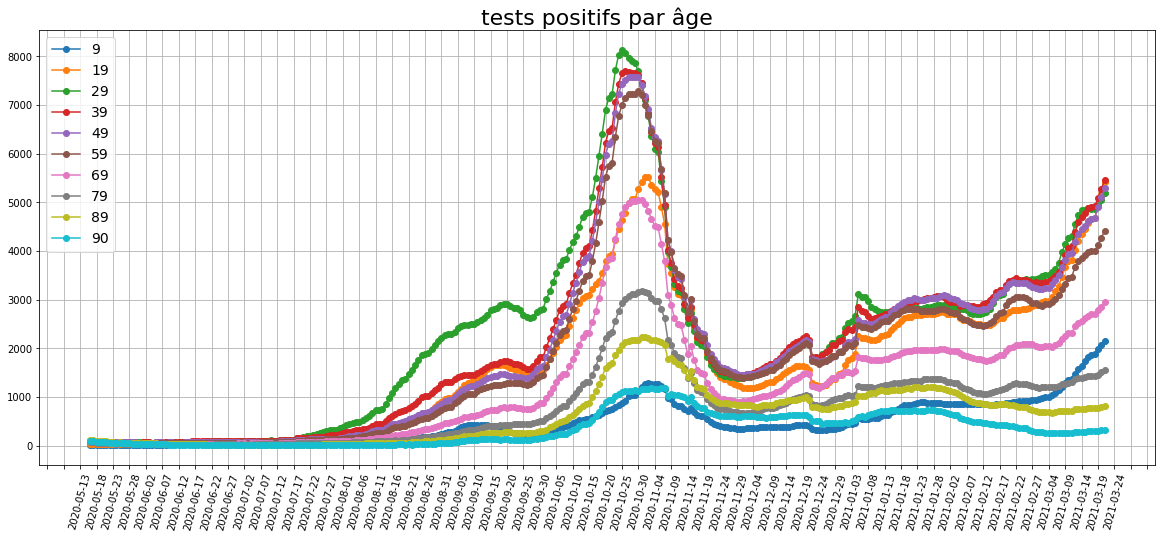

In [ ]:
df = test_age[test_age.cl_age90 > 0]
df = df.pivot_table(index="jour", columns="cl_age90", values="P", aggfunc=sum).rolling(7, center=True).mean()
display_df(df, title="tests positifs par âge")

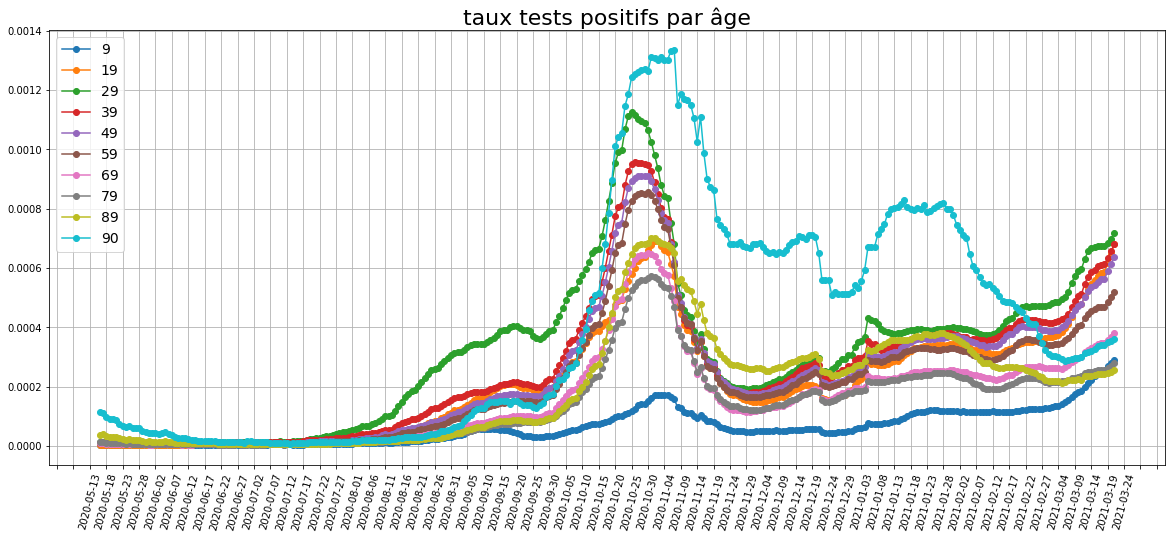

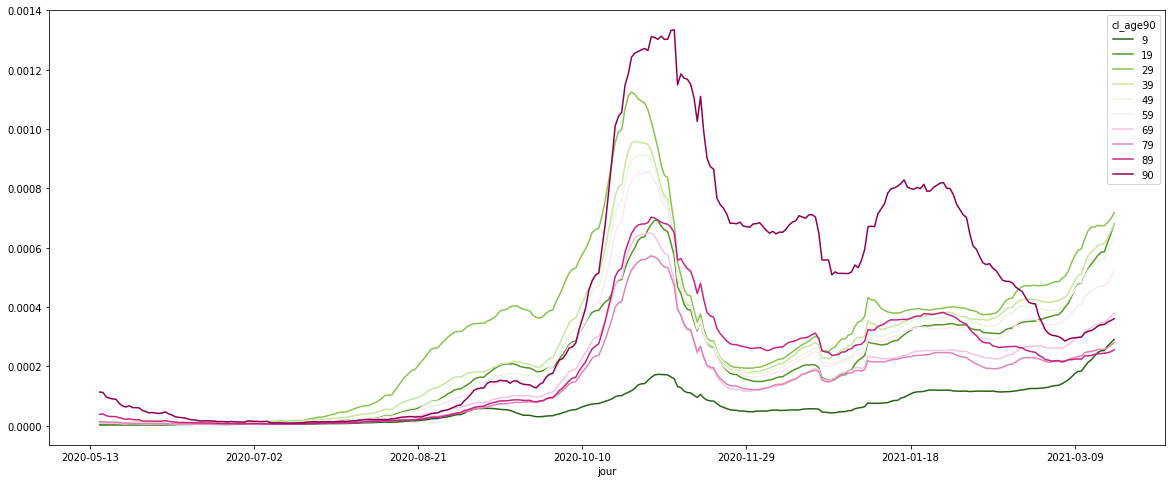

In [ ]:
df = test_age[test_age.cl_age90 > 0]
df = df.pivot_table(index="jour", columns="cl_age90", values="P_norm", aggfunc=sum).rolling(7, center=True).mean()
display_df(df, title="taux tests positifs par âge")

colors = pl.cm.PiYG(np.linspace(0,1,df.shape[1]))[::-1]
df.plot(color=colors)

In [ ]:
df.head()
fig = go.Figure(data=go.Heatmap(
    z=df.T,
    x=df.index,
    y=np.arange(9,100,10), #df.columns,
    colorscale = 'Viridis',
    )
)
fig.update_layout(title="taux de tests positifs par âge")
fig.show()

# réanimations

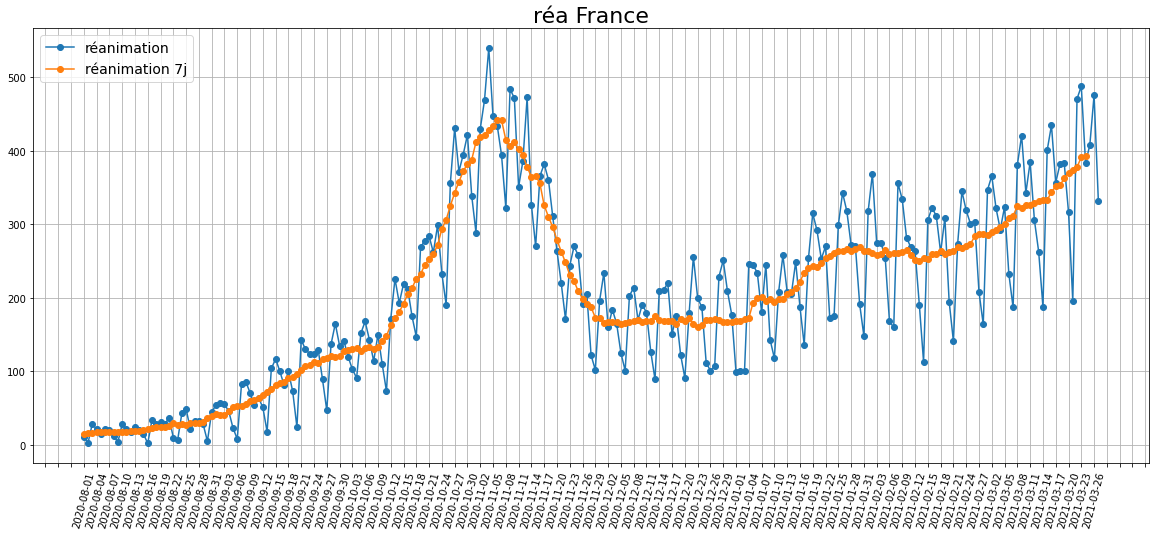


dernières données :
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2021-03-24      2130.0      384.0      1817.0      394.0

hospitalisations pour 100k habitants 2.70
réanimations pour 100k habitants     0.59


In [ ]:
display_rea_dept(min_date="2020-08-01")

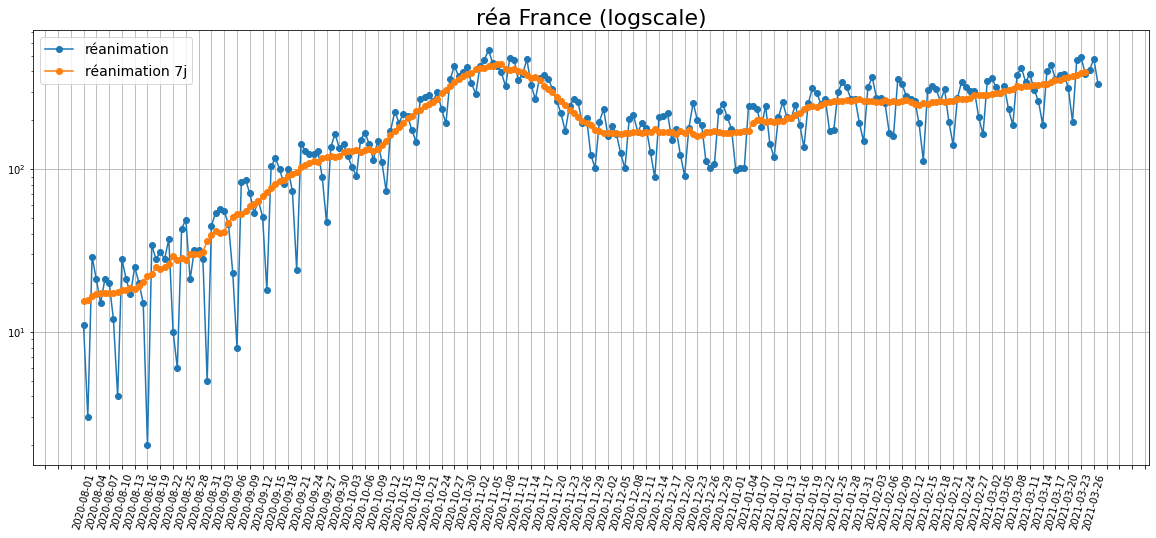


dernières données :
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2021-03-24      2130.0      384.0      1817.0      394.0

hospitalisations pour 100k habitants 2.70
réanimations pour 100k habitants     0.59


In [ ]:
display_rea_dept(min_date="2020-08-01", logscale=True)

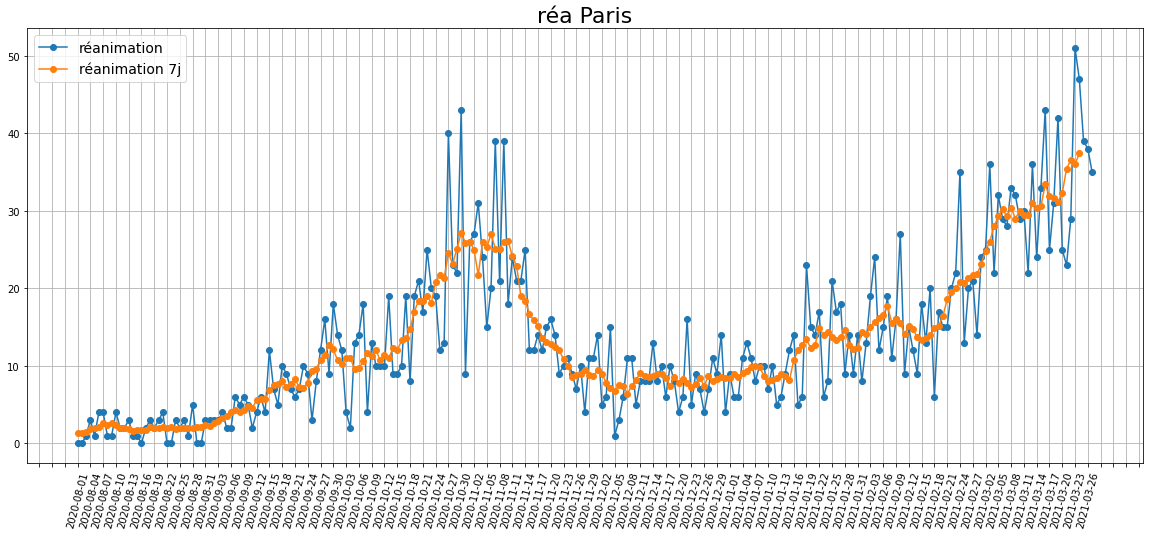


dernières données :
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2021-03-24       149.0       47.0       119.0       37.0

hospitalisations pour 100k habitants 5.49
réanimations pour 100k habitants     1.73


In [ ]:
display_rea_dept(dept="75",min_date="2020-08-01")

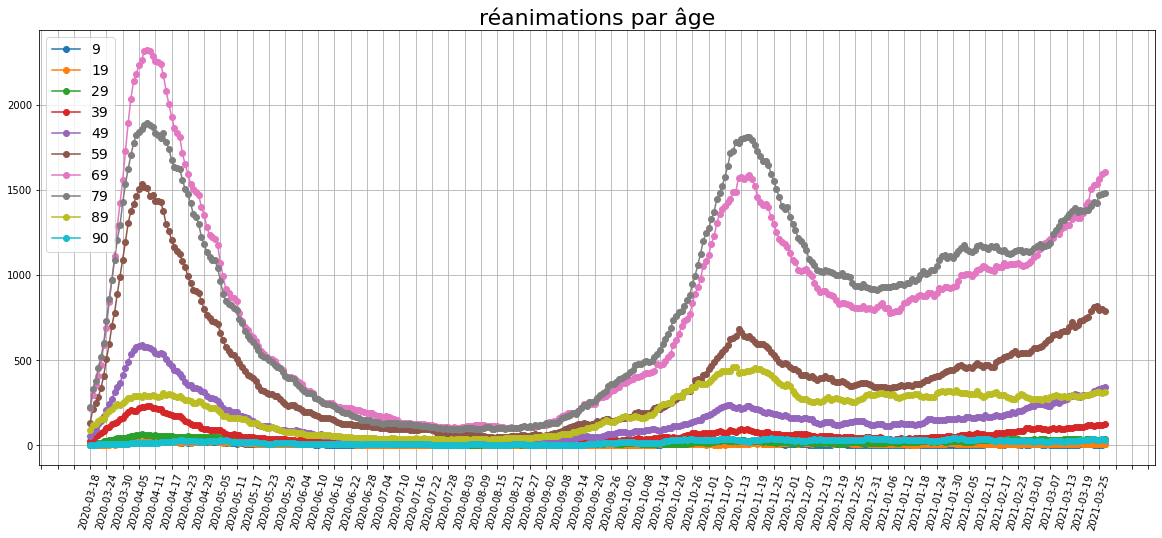

In [ ]:
display_df(window(prepare_rea_age()),title="réanimations par âge")

In [ ]:
df = prepare_rea_age(normalize=True)
df.head()
fig = go.Figure(data=go.Heatmap(
    z=df.T,
    x=df.index,
    y=np.arange(9,100,10), #df.columns
    colorscale = 'Viridis')
)
fig.show()

# SOS médecins et urgences

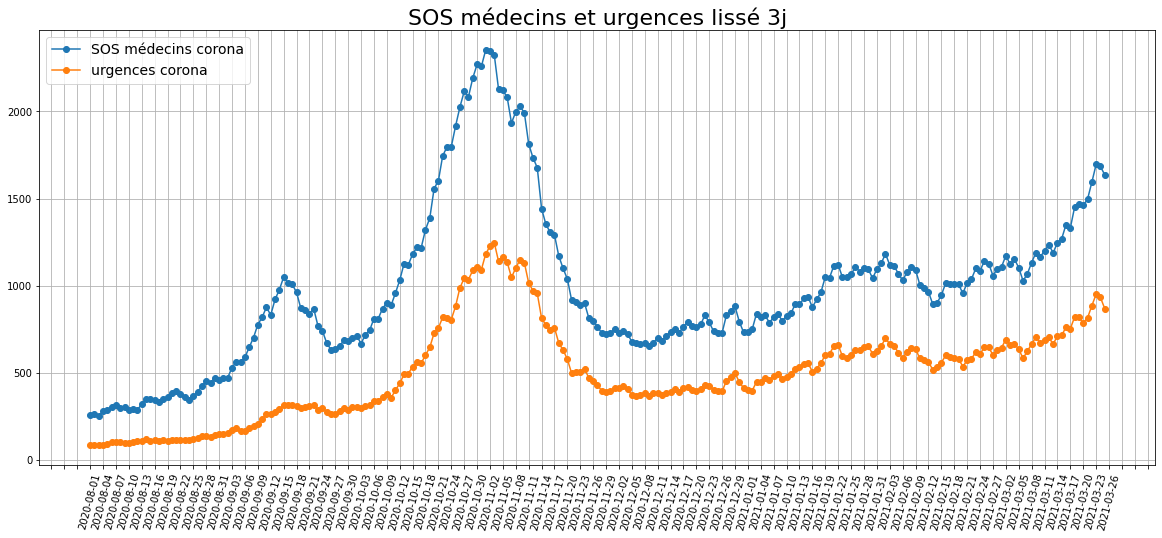

In [ ]:
lissage = 3
display_df(window(
    sos_urgences.groupby(["date_de_passage"])[["nbre_pass_corona", "nbre_hospit_corona"]].sum().rolling(lissage, center=True).mean(),
    min_date="2020-08-01"),
    legend=["SOS médecins corona", "urgences corona"],
    title = f"SOS médecins et urgences lissé {lissage}j"
)

In [ ]:
display_df(window(prepare_rea_age([59, 69, 79, 89, 90], normalize=True)),title="taux de réanimation par âge")

colors = pl.cm.PiYG(np.linspace(0,1,df.shape[1]))[::-1]
df.plot(color=colors)

# stock

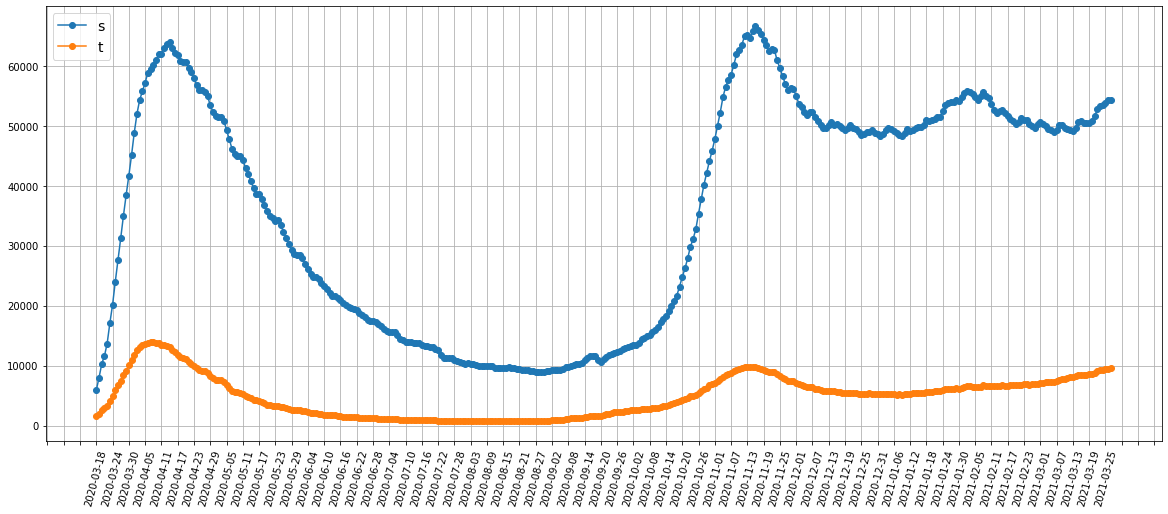

In [ ]:
c = cumul.groupby(["jour"])[["hosp", "rea"]].sum()
display_df(c, "stock")

In [ ]:
display_df(c, logscale=True, title="stock")

In [ ]:
c = cumul.groupby(["jour"])[["hosp", "rea"]].sum().reset_index()
c = c.melt(id_vars= ["jour"], value_vars=["hosp", "rea"])
fig=px.line(c, x="jour", y="value",color="variable")
fig.show()

In [ ]:
d = cumul[cumul.dep=="06"].groupby(["jour"])[["hosp", "rea"]].sum()
display_df(d, "stock")

In [ ]:
d = cumul[cumul.dep=="75"].groupby(["jour"])[["hosp", "rea"]].sum()
display_df(d, "stock")

In [ ]:
d = cumul[cumul.dep=="05"].groupby(["jour"])[["hosp", "rea"]].sum()
display_df(d, "stock")